---

_You are currently looking at **version 1.0** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-data-analysis/resources/0dhYG) course resource._

---

Last week, we were introduced to the pandas data manipulation and analysis library. We saw that there is really two-core data structures which are very similar,
- the one-dimensional __series__ object and 
- the two-dimensional __DataFrame__ object. 

Querying these two data structures is done in a few _different_ ways, such as using the 
- iloc or loc attributes for __row-based__ querying, or using the 
- square brackets on the object itself for __column-based__ querying. 

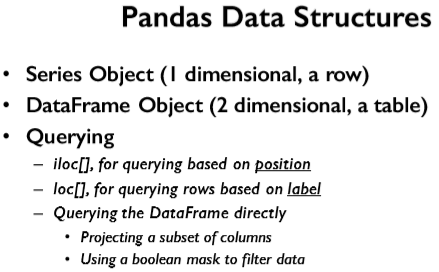

Most importantly, we saw that one can query the DataFrame and Series objects through __Boolean masking__. And Boolean masking is a powerful filtering method which allows us to use __broadcasting__ to determine what data should be kept in our analysis. 

In this week's lecture, we're going to go into more detail on how to manipulate DataFrame, in particular.
- We're going to explore how to _reduce_ and _process_ data using __GroupBy__ and __Apply__, and 
- how to _join_ data sets from multiple files together into one. 
- We'll also talk about some features that pandas has which are useful for both traditional statistical analyses and machine learning. 

# Merging Dataframes

Let's start with how to merge data sets.

We've already seen how we add new data to an existing DataFrame. We simply use the square bracket operator with the new column name, and the data is added as long as an index is shared. 

If there is no shared index and a scalar value is passed in (which remember a scalar value is just a single value like an integer or a string), the new value column is added with the scalar value as the default value. 

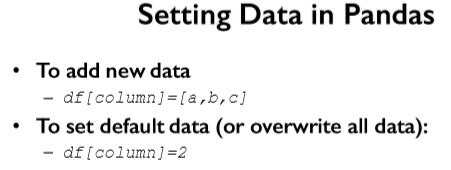

What if we wanted to assign a different value for every row? Well, it gets trickier. If we could hardcode the values into a list, then pandas will unpack them and assign them to the rows. But if the list we have isn't long enough, then we can't do this, since Pandas doesn't know where the missing values should go. 

Here's an example. We used the DataFrame of store purchases from one of our previous lectures, where the index is a list of stores and the columns store purchase data. 



In [82]:
import pandas as pd

df = pd.DataFrame([{'Name': 'Chris', 'Item Purchased': 'Sponge', 'Cost': 22.50},
                   {'Name': 'Kevyn', 'Item Purchased': 'Kitty Litter', 'Cost': 2.50},
                   {'Name': 'Filip', 'Item Purchased': 'Spoon', 'Cost': 5.00}],
                  index=['Store 1', 'Store 1', 'Store 2'])
df

,Cost,Item Purchased,Name
Store 1,22.5,Sponge,Chris
Store 1,2.5,Kitty Litter,Kevyn
Store 2,5.0,Spoon,Filip


If we want to add some new column called Date to the DataFrame, that's fine. We just use the square bracket operator directly on the DataFrame, as long as the column is as long as the rest of the records. 

In [83]:
df['Date'] = ['December 1', 'January 1', 'mid-May']
df

,Cost,Item Purchased,Name,Date
Store 1,22.5,Sponge,Chris,December 1
Store 1,2.5,Kitty Litter,Kevyn,January 1
Store 2,5.0,Spoon,Filip,mid-May


If we want to add some new field, may be a delivery flag, that's easy too since it's a scalar value. 

In [84]:
df['Delivered'] = True
df

,Cost,Item Purchased,Name,Date,Delivered
Store 1,22.5,Sponge,Chris,December 1,True
Store 1,2.5,Kitty Litter,Kevyn,January 1,True
Store 2,5.0,Spoon,Filip,mid-May,True


The problem comes in when we have only a few items to add. In order for this to work, we have to supply pandas the list which is long enough for the DataFrame, so that each row could be populated. 

This means that we have to input None values ourselves. If each of our rows has a unique index, then we could just assign the new column identifier to the series. 


In [85]:
df['Feedback'] = ['Positive', None, 'Negative']
df

,Cost,Item Purchased,Name,Date,Delivered,Feedback
Store 1,22.5,Sponge,Chris,December 1,True,Positive
Store 1,2.5,Kitty Litter,Kevyn,January 1,True,None
Store 2,5.0,Spoon,Filip,mid-May,True,Negative


For instance, if we reset the index in this example so the DataFrame is labeled from 1 through 2, then we create a new series with these labels, we can apply it. And the results we get are as we expected. 

The nice aspect of this approach is that we could just ignore the items that we don't know about, and pandas will put missing values in for us. So this is a really nice way to do it.

In [86]:
#can ignore values that we don't know and Pandas will put NaN in there
adf = df.reset_index()
adf['Date'] = pd.Series({0: 'December 1', 2: 'mid-May'})
adf

,index,Cost,Item Purchased,Name,Date,Delivered,Feedback
0,Store 1,22.5,Sponge,Chris,December 1,True,Positive
1,Store 1,2.5,Kitty Litter,Kevyn,NaN,True,None
2,Store 2,5.0,Spoon,Filip,mid-May,True,Negative


More commonly, we want to join two larger DataFrames together, and this is a bit more complex. Before we jump into the code, we need to address a little relational theory, and to get some language conventions down. This is a Venn Diagram.

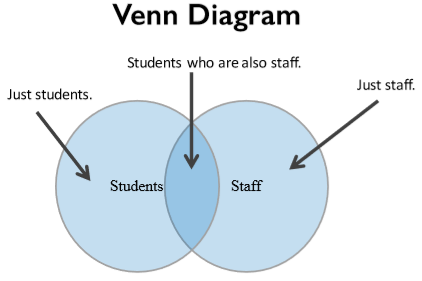

A Venn Diagram is traditionally used to show set membership. For example, the circle on the left is the population of students at a university. The circle on the right is the population of staff at a university. And the overlapping region in the middle are all of those students who are also staff. Maybe these students run tutorials for a course, or grade assignments, or engage in running research experiments. 

We could think of these two populations as indices in separate DataFrames, maybe with the label of Person Name. When we want to join the DataFrames together, we have some choices to make. 


First what if we want a list of all the people _regardless_ of whether they're staff or student, and all of the information we can get on them?
- In database terminology, this is called a __full outer join__. 
- And in set theory, it's called a __union__.

In the Venn diagram, it represents everyone in any circle. 

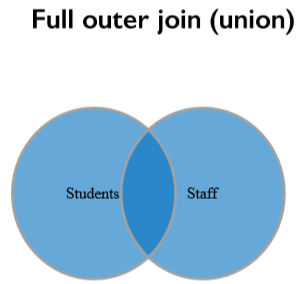


It's quite possible though that we only want those people who we have maximum information for, those people who are both staff and students.
- In database terminology, this is called an __inner join__. 
- Or in set theory, the __intersection__.

And this is represented in the Venn diagram as the overlapping parts of each circle. 

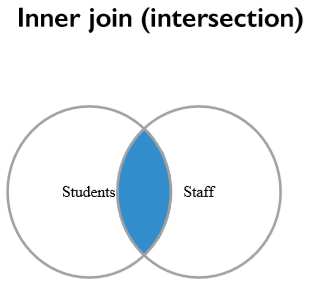

Okay, so let's see an example of how we would do this in pandas, where we would use the merge function. 

First we create two DataFrames, staff and students. There's some overlap in these DataFrames, in that James and Sally are both students and staff, but Mike and Kelly are not. 

Importantly, _both_ DataFrames are indexed along the value we want to merge them on, which is called Name. 

In [87]:
staff_df = pd.DataFrame([{'Name': 'Kelly', 'Role': 'Director of HR'},
                         {'Name': 'Sally', 'Role': 'Course liasion'},
                         {'Name': 'James', 'Role': 'Grader'}])
staff_df = staff_df.set_index('Name')
student_df = pd.DataFrame([{'Name': 'James', 'School': 'Business'},
                           {'Name': 'Mike', 'School': 'Law'},
                           {'Name': 'Sally', 'School': 'Engineering'}])
student_df = student_df.set_index('Name')
print(staff_df.head())
print()
print(student_df.head())

                 Role
Name                 
Kelly  Director of HR
Sally  Course liasion
James          Grader

            School
Name              
James     Business
Mike           Law
Sally  Engineering


If we want the __union__ of these, we would call merge, passing... 
- in the DataFrame on the left and 
- the DataFrame on the right, and
- telling merge that we want it to use an outer join. 
- We tell merge that we want to use the _left_ and _right indices_ as the joining columns. 

We see in the resulting DataFrame that everyone is listed. And since Mike does not have a role, and John does not have a school, those cells are listed as missing values.

In [88]:
pd.merge(staff_df, student_df, how='outer', left_index=True, right_index=True)

,Role,School
Name,,
James,Grader,Business
Kelly,Director of HR,NaN
Mike,NaN,Law
Sally,Course liasion,Engineering


If we wanted to get the intersection, that is, just those students who are also staff, we could set the how attribute to inner. 

And we set the resulting DataFrame has only James and Sally in it. 

In [89]:
pd.merge(staff_df, student_df, how='inner', left_index=True, right_index=True)

,Role,School
Name,,
Sally,Course liasion,Engineering
James,Grader,Business


Now there are two other common use cases when merging DataFrames.

Both are examples of what we would call __set addition__. 

The first is when we would want to get a list of all staff regardless of whether they were students or not. But if they were students, we would want to get their student details as well. To do this we would use a __left join__.

In [90]:
pd.merge(staff_df, student_df, how='left', left_index=True, right_index=True)

,Role,School
Name,,
Kelly,Director of HR,NaN
Sally,Course liasion,Engineering
James,Grader,Business


You could probably guess what comes next. We want a list of all of the students and their roles if they were also staff. To do this we would do a __right join__. 

In [91]:
pd.merge(staff_df, student_df, how='right', left_index=True, right_index=True)

,Role,School
Name,,
James,Grader,Business
Mike,NaN,Law
Sally,Course liasion,Engineering


The merge method has a couple of other interesting parameters.

First, you don't need to use indices to join on, you can use _columns_ as well.

Here's an example. 

In [92]:
#can also merge based on columns (vs. indices as shown above)
staff_df = staff_df.reset_index()
student_df = student_df.reset_index()
pd.merge(staff_df, student_df, how='left', left_on='Name', right_on='Name')

,Name,Role,School
0,Kelly,Director of HR,NaN
1,Sally,Course liasion,Engineering
2,James,Grader,Business


So what happens when we have conflicts between the DataFrames? 

Let's take a look by creating new staff and student DataFrames that have a location information added to them. In the staff DataFrame, this is an office location where we can find the staff person. And we can see the Director of HR is on State Street, while the two students are on Washington Avenue. 

But for the student DataFrame, the location information is actually their home address. 

The merge function preserves this information, but __appends__ an \_x or \_y to help differentiate between which index went with which column of data. 

The x is always the left DataFrame information, and the y is always the right DataFrame information. And you could control the names of \_x and \_y with additional parameters if you want to. 

In [93]:
staff_df = pd.DataFrame([{'Name': 'Kelly', 'Role': 'Director of HR', 'Location': 'State Street'},
                         {'Name': 'Sally', 'Role': 'Course liasion', 'Location': 'Washington Avenue'},
                         {'Name': 'James', 'Role': 'Grader', 'Location': 'Washington Avenue'}])
student_df = pd.DataFrame([{'Name': 'James', 'School': 'Business', 'Location': '1024 Billiard Avenue'},
                           {'Name': 'Mike', 'School': 'Law', 'Location': 'Fraternity House #22'},
                           {'Name': 'Sally', 'School': 'Engineering', 'Location': '512 Wilson Crescent'}])
pd.merge(staff_df, student_df, how='left', left_on='Name', right_on='Name')

,Location_x,Name,Role,Location_y,School
0,State Street,Kelly,Director of HR,NaN,NaN
1,Washington Avenue,Sally,Course liasion,512 Wilson Crescent,Engineering
2,Washington Avenue,James,Grader,1024 Billiard Avenue,Business


##  Quiz 
Now you try it. Here's a DataFrame of products and invoices. 
- The product has an identifier and a sticker price. 
- The invoice lists the people, products, identifiers, and quantity. 

Assuming that we want to generate totals, how do we join these two DataFrames together so that we have one which lists all of the information we need?

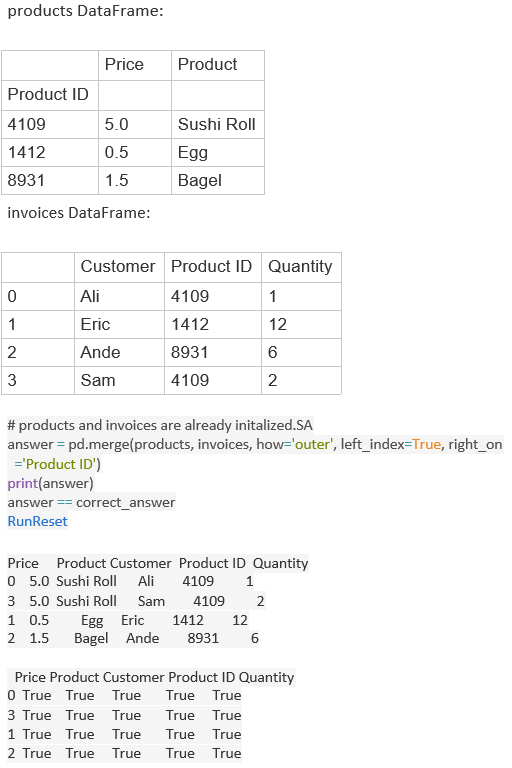


Before we leave merging of DataFrames, let's talk about
- __multi-indexing__ and
- multiple columns. 
 
It's quite possible that the first name for students and staff might overlap, but the last name might not. 

In this case, we use a list of the multiple columns that should be used to join keys on the left_on and right_on parameters. As you see here, James Wilde and James Hammond don't match on both keys. So the inner join doesn't include these individuals in the output, and only Sally Brooks is retained. 



In [94]:
#Here the merge uses both first AND last names. Otherwise if it just included last names, then inner join would include both James Wilde and James Hammond
staff_df = pd.DataFrame([{'First Name': 'Kelly', 'Last Name': 'Desjardins', 'Role': 'Director of HR'},
                         {'First Name': 'Sally', 'Last Name': 'Brooks', 'Role': 'Course liasion'},
                         {'First Name': 'James', 'Last Name': 'Wilde', 'Role': 'Grader'}])
student_df = pd.DataFrame([{'First Name': 'James', 'Last Name': 'Hammond', 'School': 'Business'},
                           {'First Name': 'Mike', 'Last Name': 'Smith', 'School': 'Law'},
                           {'First Name': 'Sally', 'Last Name': 'Brooks', 'School': 'Engineering'}])
staff_df
student_df
pd.merge(staff_df, student_df, how='inner', left_on=['First Name','Last Name'], right_on=['First Name','Last Name'])

,First Name,Last Name,Role,School
0,Sally,Brooks,Course liasion,Engineering


That's it for merging of DataFrames. pandas has a lot more options in the area, but I think the merge function is perhaps the most easiest to understand and the most flexible. 

In the next section, we're going to talk about how to write idiomatic pandas and delve a bit deeper into more advanced functions for manipulating DataFrames.

# Idiomatic Pandas: Making Code Pandorable

Python programmers will often suggest that there many ways the language can be used to solve a particular problem. But that some are more appropriate than others. The best solutions are celebrated as _Idiomatic Python_ and there are lots of great examples of this on stack overflow and websites.

> An idiomatic solution is often one which has both _high performance_ __and__ _high readability_. 

This isn't necessarily true. A sort of sub-language within Python, Pandas has its own set of idioms. We've alluded to some of these already, such as
- using vectorization whenever possible, and
- not using iterative loops if you don't need to. 

Several developers and users within the Panda's community have used the term pandorable for these idioms. I think it's a great term.

So, I wanted to share with you a couple of key features of how you can make your code pandorable.

### Method Chaining

The first of these is called __method chaining__. 

Now we saw that previously, you could chain pandas calls together when you're querying DataFrames. For, instance if you wanted to select rows based on index like county name. Then you wanted to only project certain columns like the total population, you can write a query, like df.loc[“Washtenaw”][“Total Population”]. This is a form of chaining, called chain indexing. And it's generally a __bad practice__. Because it's possible that pandas could be returning a copy or a view of the DataFrame depending upon the underlying NumPy library. 

> In his descriptions of idiomatic Pandas patterns developer Tom Osberger described a rule of thumb for this. If you see back to back square brackets, then you should think carefully if you want to be doing chain indexing. I think this is great as a sort of code smell or anti pattern. 

Method chaining though, little bit _different_. The general idea behind method chaining is that ___every method on an object returns a reference to that object___. The beauty of this is that you can condense many different operations on a DataFrame, for instance, into one line or at least one statement of code. 

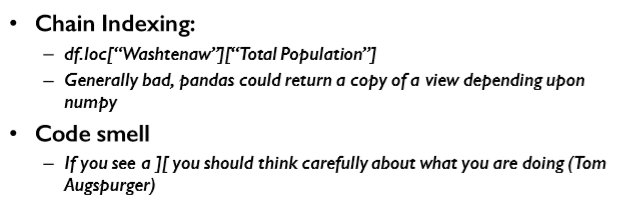


Here's an example of two pieces of code in pandas using our census data.

The first is the pandorable way to write the code with method chaining. In this code, there's no "in_place" flag being used and you can see that when we first run a where query, then a dropna, then a set_index, and then a rename. You might wonder why the whole statement is enclosed in parentheses and that's just to make the statement more readable. 

> In Python, if you begin with an open parentheses, you can span a statement over multiple lines and things read a little bit nicer. 

In [95]:
import pandas as pd
df = pd.read_csv('census.csv')
df.head()

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,...,RDOMESTICMIG2011,RDOMESTICMIG2012,RDOMESTICMIG2013,RDOMESTICMIG2014,RDOMESTICMIG2015,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015
0,40,3,6,1,0,Alabama,Alabama,4779736,4780127,4785161,...,0.002295,-0.193196,0.381066,0.582002,-0.467369,1.030015,0.826644,1.383282,1.724718,0.712594
1,50,3,6,1,1,Alabama,Autauga County,54571,54571,54660,...,7.242091,-2.915927,-3.012349,2.265971,-2.530799,7.606016,-2.626146,-2.722002,2.592270,-2.187333
2,50,3,6,1,3,Alabama,Baldwin County,182265,182265,183193,...,14.832960,17.647293,21.845705,19.243287,17.197872,15.844176,18.559627,22.727626,20.317142,18.293499
3,50,3,6,1,5,Alabama,Barbour County,27457,27457,27341,...,-4.728132,-2.500690,-7.056824,-3.904217,-10.543299,-4.874741,-2.758113,-7.167664,-3.978583,-10.543299
4,50,3,6,1,7,Alabama,Bibb County,22915,22919,22861,...,-5.527043,-5.068871,-6.201001,-0.177537,0.177258,-5.088389,-4.363636,-5.403729,0.754533,1.107861


In [96]:
(df.where(df['SUMLEV']==50)
    .dropna()
    .set_index(['STNAME','CTYNAME'])
    .rename(columns={'ESTIMATESBASE2010': 'Estimates Base 2010'})
    .head())

SUMLEV  REGION  DIVISION  STATE  COUNTY  \
STNAME  CTYNAME                                                   
Alabama Autauga County    50.0     3.0       6.0    1.0     1.0   
        Baldwin County    50.0     3.0       6.0    1.0     3.0   
        Barbour County    50.0     3.0       6.0    1.0     5.0   
        Bibb County       50.0     3.0       6.0    1.0     7.0   
        Blount County     50.0     3.0       6.0    1.0     9.0   

                        CENSUS2010POP  Estimates Base 2010  POPESTIMATE2010  \
STNAME  CTYNAME                                                               
Alabama Autauga County        54571.0              54571.0          54660.0   
        Baldwin County       182265.0             182265.0         183193.0   
        Barbour County        27457.0              27457.0          27341.0   
        Bibb County           22915.0              22919.0          22861.0   
        Blount County         57322.0              57322.0          57373.0   

                        POPESTIMATE2011  POPESTIMATE2012     ...       \
STNAME  CTYNAME                                              ...        
Alabama Autauga County          55253.0          55175.0     ...        
        Baldwin County         186659.0         190396.0     ...        
        Barbour County          27226.0          27159.0     ...        
        Bibb County             22733.0          22642.0     ...        
        Blount County           57711.0          57776.0     ...        

                        RDOMESTICMIG2011  RDOMESTICMIG2012  RDOMESTICMIG2013  \
STNAME  CTYNAME                                                                
Alabama Autauga County          7.242091         -2.915927         -3.012349   
        Baldwin County         14.832960         17.647293         21.845705   
        Barbour County         -4.728132         -2.500690         -7.056824   
        Bibb County            -5.527043         -5.068871         -6.201001   
        Blount County           1.807375         -1.177622         -1.748766   

                        RDOMESTICMIG2014  RDOMESTICMIG2015  RNETMIG2011  \
STNAME  CTYNAME                                                           
Alabama Autauga County          2.265971         -2.530799     7.606016   
        Baldwin County         19.243287         17.197872    15.844176   
        Barbour County         -3.904217        -10.543299    -4.874741   
        Bibb County            -0.177537          0.177258    -5.088389   
        Blount County          -2.062535         -1.369970     1.859511   

                        RNETMIG2012  RNETMIG2013  RNETMIG2014  RNETMIG2015  
STNAME  CTYNAME                                                             
Alabama Autauga County    -2.626146    -2.722002     2.592270    -2.187333  
        Baldwin County    18.559627    22.727626    20.317142    18.293499  
        Barbour County    -2.758113    -7.167664    -3.978583   -10.543299  
        Bibb County       -4.363636    -5.403729     0.754533     1.107861  
        Blount County     -0.848580    -1.402476    -1.577232    -0.884411  

[5 rows x 98 columns]

The second example is a more traditional way of writing code. There's nothing wrong with this code in the functional sense, you might even be able to understand it better as a new person to the language. It's just not as pandorable as the first example. Now, the key with any good idiom is to understand when it isn't helping you. In this case, you can actually time both methods and see that the latter method is faster. So, this is a particular example of a classic time readability trade off. 

You'll see lots of examples on stack overflow and in documentation of people using method chaining in their pandas. And so, I think being able to read and understand the syntax is really worth your time. 

Here's another pandas idiom. 

### Map

Python has a wonderful function called __map__, which is sort of a basis for functional programming in the language. 

When you want to use map in Python, you
- pass it some function you want called, and 
- some iterable, like a list, that you want the function to be applied to.
- The results are that the function is called against each item in the list, and 
- there's a resulting list of all of the evaluations of that function.

### Applymap
Python has a similar function called __applymap__. 

In applymap, you provide 
- some function which should operate on each cell of a DataFrame, and 
- the return set is itself a DataFrame. 

### Apply

Now I think applymap is fine, but I actually rarely use it. Instead, I find myself often wanting to map across all of the rows in a DataFrame. 

And pandas has a function that I use heavily there, called __apply__. 

Let's look at an example. Let's take our census DataFrame. In this DataFrame, we have five columns for population estimates. Each column corresponding with one year of estimates. 

In [97]:
df = df[df['SUMLEV']==50]
df.set_index(['STNAME','CTYNAME'], inplace=True)
df.rename(columns={'ESTIMATESBASE2010': 'Estimates Base 2010'}).head()

SUMLEV  REGION  DIVISION  STATE  COUNTY  \
STNAME  CTYNAME                                                   
Alabama Autauga County      50       3         6      1       1   
        Baldwin County      50       3         6      1       3   
        Barbour County      50       3         6      1       5   
        Bibb County         50       3         6      1       7   
        Blount County       50       3         6      1       9   

                        CENSUS2010POP  Estimates Base 2010  POPESTIMATE2010  \
STNAME  CTYNAME                                                               
Alabama Autauga County          54571                54571            54660   
        Baldwin County         182265               182265           183193   
        Barbour County          27457                27457            27341   
        Bibb County             22915                22919            22861   
        Blount County           57322                57322            57373   

                        POPESTIMATE2011  POPESTIMATE2012     ...       \
STNAME  CTYNAME                                              ...        
Alabama Autauga County            55253            55175     ...        
        Baldwin County           186659           190396     ...        
        Barbour County            27226            27159     ...        
        Bibb County               22733            22642     ...        
        Blount County             57711            57776     ...        

                        RDOMESTICMIG2011  RDOMESTICMIG2012  RDOMESTICMIG2013  \
STNAME  CTYNAME                                                                
Alabama Autauga County          7.242091         -2.915927         -3.012349   
        Baldwin County         14.832960         17.647293         21.845705   
        Barbour County         -4.728132         -2.500690         -7.056824   
        Bibb County            -5.527043         -5.068871         -6.201001   
        Blount County           1.807375         -1.177622         -1.748766   

                        RDOMESTICMIG2014  RDOMESTICMIG2015  RNETMIG2011  \
STNAME  CTYNAME                                                           
Alabama Autauga County          2.265971         -2.530799     7.606016   
        Baldwin County         19.243287         17.197872    15.844176   
        Barbour County         -3.904217        -10.543299    -4.874741   
        Bibb County            -0.177537          0.177258    -5.088389   
        Blount County          -2.062535         -1.369970     1.859511   

                        RNETMIG2012  RNETMIG2013  RNETMIG2014  RNETMIG2015  
STNAME  CTYNAME                                                             
Alabama Autauga County    -2.626146    -2.722002     2.592270    -2.187333  
        Baldwin County    18.559627    22.727626    20.317142    18.293499  
        Barbour County    -2.758113    -7.167664    -3.978583   -10.543299  
        Bibb County       -4.363636    -5.403729     0.754533     1.107861  
        Blount County     -0.848580    -1.402476    -1.577232    -0.884411  

[5 rows x 98 columns]

It's quite reasonable to want to create some new columns for minimum or maximum values, and the __apply__ function is an easy way to do this. 

- First, we need to write a function which takes in a particular row of data, finds a minimum and maximum values, and returns a new row of data. We'll call this function min_max, this is pretty straight forward. We can create some small slice of a row by projecting the population columns. 
- Then use the NumPy min and max functions, and create a new series with a label values represent the new values we want to apply. 


In [101]:
#each time min_max is called, returns a series of a min and a max
import numpy as np
def min_max(row):
    data = row[['POPESTIMATE2010',
                'POPESTIMATE2011',
                'POPESTIMATE2012',
                'POPESTIMATE2013',
                'POPESTIMATE2014',
                'POPESTIMATE2015']]
    return pd.Series({'min': np.min(data), 'max': np.max(data)})

Then we just need to call apply on the DataFrame. 

__Apply__ takes
- the function and 
- the axis on which to operate as parameters. 

Now, we have to be a bit careful, we've talked about __axis__ zero being the rows of the DataFrame in the past. 

<font color='red'>But this parameter is _really_ the parameter of the __index__ to use. </font>

So, to apply across all rows, you pass axis equal to one. 

In [102]:
#apply applies function along input axis of dataframe. 
# Axis=0 refers to index (applies to each col)
# Axis=1 refers to columns (applies to each row)
df.apply(min_max, axis=1).head()

max       min
STNAME  CTYNAME                           
Alabama Autauga County   55347.0   54660.0
        Baldwin County  203709.0  183193.0
        Barbour County   27341.0   26489.0
        Bibb County      22861.0   22512.0
        Blount County    57776.0   57373.0

Of course there's no need to limit yourself to returning a new series object. If you're doing this as part of data cleaning you're likely to find yourself wanting to add new data to the existing DataFrame. 

In that case you just take the row values and add in new columns indicating the max and minimum scores. This is a regular part of my workflow when bringing in data and building summary or descriptive statistics. And is often used heavily with the merging of DataFrames. 

In [103]:
#instead of returning a separate dataframe, can simply integrate summary stats (min, max) as extra columns at the end
import numpy as np
def min_max(row):
    data = row[['POPESTIMATE2010',
                'POPESTIMATE2011',
                'POPESTIMATE2012',
                'POPESTIMATE2013',
                'POPESTIMATE2014',
                'POPESTIMATE2015']]
    row['max'] = np.max(data)
    row['min'] = np.min(data)
    return row
df.apply(min_max, axis=1).head()

SUMLEV  REGION  DIVISION  STATE  COUNTY  \
STNAME  CTYNAME                                                   
Alabama Autauga County    50.0     3.0       6.0    1.0     1.0   
        Baldwin County    50.0     3.0       6.0    1.0     3.0   
        Barbour County    50.0     3.0       6.0    1.0     5.0   
        Bibb County       50.0     3.0       6.0    1.0     7.0   
        Blount County     50.0     3.0       6.0    1.0     9.0   

                        CENSUS2010POP  ESTIMATESBASE2010  POPESTIMATE2010  \
STNAME  CTYNAME                                                             
Alabama Autauga County        54571.0            54571.0          54660.0   
        Baldwin County       182265.0           182265.0         183193.0   
        Barbour County        27457.0            27457.0          27341.0   
        Bibb County           22915.0            22919.0          22861.0   
        Blount County         57322.0            57322.0          57373.0   

                        POPESTIMATE2011  POPESTIMATE2012    ...     \
STNAME  CTYNAME                                             ...      
Alabama Autauga County          55253.0          55175.0    ...      
        Baldwin County         186659.0         190396.0    ...      
        Barbour County          27226.0          27159.0    ...      
        Bibb County             22733.0          22642.0    ...      
        Blount County           57711.0          57776.0    ...      

                        RDOMESTICMIG2013  RDOMESTICMIG2014  RDOMESTICMIG2015  \
STNAME  CTYNAME                                                                
Alabama Autauga County         -3.012349          2.265971         -2.530799   
        Baldwin County         21.845705         19.243287         17.197872   
        Barbour County         -7.056824         -3.904217        -10.543299   
        Bibb County            -6.201001         -0.177537          0.177258   
        Blount County          -1.748766         -2.062535         -1.369970   

                        RNETMIG2011  RNETMIG2012  RNETMIG2013  RNETMIG2014  \
STNAME  CTYNAME                                                              
Alabama Autauga County     7.606016    -2.626146    -2.722002     2.592270   
        Baldwin County    15.844176    18.559627    22.727626    20.317142   
        Barbour County    -4.874741    -2.758113    -7.167664    -3.978583   
        Bibb County       -5.088389    -4.363636    -5.403729     0.754533   
        Blount County      1.859511    -0.848580    -1.402476    -1.577232   

                        RNETMIG2015       max       min  
STNAME  CTYNAME                                          
Alabama Autauga County    -2.187333   55347.0   54660.0  
        Baldwin County    18.293499  203709.0  183193.0  
        Barbour County   -10.543299   27341.0   26489.0  
        Bibb County        1.107861   22861.0   22512.0  
        Blount County     -0.884411   57776.0   57373.0  

[5 rows x 100 columns]

Okay, this is all great, and __apply__ is an extremely _important_ tool in your toolkit.

But this lecture wasn't really supposed to be about the new features of the API, but about making _pandorable code_. 

### Lambdas
The reason I introduced supply here is because you rarely see it used with large function definitions, like we did. Instead, you typically see it __used with lambdas__.

Now, you'll recall from the first week of this course that knowing lambda isn't a requirement of the course. But to get the _most_ of the discussions you'll see online, you're going to need to know how at least read lambdas. 

Here's a _one line_ example of how you might calculate the max of the columns using the apply function. You can imagine how you might chain several apply calls with lambdas together to create a readable yet succinct data manipulation script. 

In [104]:
#lambdas make the code even more Pandorable
rows = ['POPESTIMATE2010',
        'POPESTIMATE2011',
        'POPESTIMATE2012',
        'POPESTIMATE2013',
        'POPESTIMATE2014',
        'POPESTIMATE2015']
df.apply(lambda x: np.max(x[rows]), axis=1).head()

STNAME   CTYNAME       
Alabama  Autauga County     55347.0
         Baldwin County    203709.0
         Barbour County     27341.0
         Bibb County        22861.0
         Blount County      57776.0
dtype: float64

In [105]:
type(df.apply(lambda x: np.max(x[rows]), axis=1))

pandas.core.series.Series

So there are a couple of pandas idioms. But I think there's many more, and I haven't talked about them here.

So here's an unofficial assignment for you. Go look at some of the top ranked questions on pandas on Stack Overflow, and look at how some of the more experienced authors, answer those questions. Do you see any interesting patterns? Chime in on the course discussion forums and let's build some pandorable documents together. 

Our next lectures is going to be on group functions and I'll see you then.

# Group by

We've seen that even though PANDAS allows us to iterate over every row in a data frame this is generally a _slow_ way to accomplish a given task and it's not very pandorable. 

For instance, if we wanted to write some code to iterate over all the of the states and generate a list of the average census population numbers, we could do so using a loop in the unique function. 

Another option is to use the dataframe __group by__ function. This function
- takes some column name or names and 
- splits the dataframe up into chunks based on those names, 
- it returns a dataframe _group by object_, Which can be iterated upon, and then 
- returns a __tuple__ where the 
    - first item is the group condition, and
    - the second item is the data frame reduced by that grouping. 

Since it's made up of two values, you can unpack this, and project just the column that you're interested in, to calculate the average. 

Here's some examples of both methods in action. 

Let's first load the census data, then exclude the state level summarizations, which had a sum level value of 40. 

In [46]:
import pandas as pd
import numpy as np
df = pd.read_csv('census.csv')
df = df[df['SUMLEV']==50]
df.head()

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,...,RDOMESTICMIG2011,RDOMESTICMIG2012,RDOMESTICMIG2013,RDOMESTICMIG2014,RDOMESTICMIG2015,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015
1,50,3,6,1,1,Alabama,Autauga County,54571,54571,54660,...,7.242091,-2.915927,-3.012349,2.265971,-2.530799,7.606016,-2.626146,-2.722002,2.592270,-2.187333
2,50,3,6,1,3,Alabama,Baldwin County,182265,182265,183193,...,14.832960,17.647293,21.845705,19.243287,17.197872,15.844176,18.559627,22.727626,20.317142,18.293499
3,50,3,6,1,5,Alabama,Barbour County,27457,27457,27341,...,-4.728132,-2.500690,-7.056824,-3.904217,-10.543299,-4.874741,-2.758113,-7.167664,-3.978583,-10.543299
4,50,3,6,1,7,Alabama,Bibb County,22915,22919,22861,...,-5.527043,-5.068871,-6.201001,-0.177537,0.177258,-5.088389,-4.363636,-5.403729,0.754533,1.107861
5,50,3,6,1,9,Alabama,Blount County,57322,57322,57373,...,1.807375,-1.177622,-1.748766,-2.062535,-1.369970,1.859511,-0.848580,-1.402476,-1.577232,-0.884411


In the first we used the census date. We get a list of the unique states. Then for each state we reduce the data frame and calculate the average.

If we time this we see it takes a while. I've set the number of loops here the time it should take to ten because I'm live loading. 

In [25]:
%%timeit -n 10
#Slow method for for loop to calculate average county population for each state
for state in df['STNAME'].unique():
    avg = np.average(df.where(df['STNAME']==state).dropna()['CENSUS2010POP'])
    print('Counties in state ' + state + ' have an average population of ' + str(avg))

Counties in state Alabama have an average population of 71339.3432836
Counties in state Alaska have an average population of 24490.7241379
Counties in state Arizona have an average population of 426134.466667
Counties in state Arkansas have an average population of 38878.9066667
Counties in state California have an average population of 642309.586207
Counties in state Colorado have an average population of 78581.1875
Counties in state Connecticut have an average population of 446762.125
Counties in state Delaware have an average population of 299311.333333
Counties in state District of Columbia have an average population of 601723.0
Counties in state Florida have an average population of 280616.567164
Counties in state Georgia have an average population of 60928.6352201
Counties in state Hawaii have an average population of 272060.2
Counties in state Idaho have an average population of 35626.8636364
Counties in state Illinois have an average population of 125790.509804
Counties in stat

Here's the same approach with a group by object. 

We tell pandas we're interested in group and with a state name and then we calculate the average using just one column and all of the data in that column. 

When we time it we see a huge difference in the speed. 

In [26]:
%%timeit -n 10
#Faster method which groups by State (as one state can have multiple counties) first prior
#groupby segments by statename and returns a "dataframe" which corresponds to ALL the counties for each state
for group, frame in df.groupby('STNAME'):
    avg = np.average(frame['CENSUS2010POP'])
    print('Counties in state ' + group + ' have an average population of ' + str(avg))

Counties in state Alabama have an average population of 71339.3432836
Counties in state Alaska have an average population of 24490.7241379
Counties in state Arizona have an average population of 426134.466667
Counties in state Arkansas have an average population of 38878.9066667
Counties in state California have an average population of 642309.586207
Counties in state Colorado have an average population of 78581.1875
Counties in state Connecticut have an average population of 446762.125
Counties in state Delaware have an average population of 299311.333333
Counties in state District of Columbia have an average population of 601723.0
Counties in state Florida have an average population of 280616.567164
Counties in state Georgia have an average population of 60928.6352201
Counties in state Hawaii have an average population of 272060.2
Counties in state Idaho have an average population of 35626.8636364
Counties in state Illinois have an average population of 125790.509804
Counties in stat

Now, 99% of the time, you'll use group by on one or more columns. But you can actually __provide a function__ to group by as well and use that to segment your data.

This is a bit of a fabricated example but lets say that you have a big batch job with lots of processing and you want to work on only a third or so of the states at a given time. 

We could create some function which returns a number between zero and two based on the first character of the state name. Then we can tell group by to use this function to split up our data frame. It's important to note that in order to do this you need to set the index of the data frame to be the column that you want to group by first.

Here's an example. 

- We'll create some new function called fun and 
- if the first letter of the parameter is a capital M we'll return a 0. 
- If it's a capital Q we'll return a 1 and 
- otherwise we'll return a 2. 
- Then we'll pass this function to the data frame reply, and see that the data frame is segmented by the calculated group number. 

This kind of technique, which is sort of a light weight hashing, is commonly used to distribute tasks across multiple workers. Whether they are cores in a processor, nodes in a supercomputer, or disks in a database.

In [28]:
#need to first set index of the dataframe to be the column that will be grouped by
df = df.set_index('STNAME')

def fun(item):
    if item[0]<'M':
        return 0
    if item[0]<'Q':
        return 1
    return 2

for group, frame in df.groupby(fun):
    print('There are ' + str(len(frame)) + ' records in group ' + str(group) + ' for processing.')


There are 1177 records in group 0 for processing.
There are 1134 records in group 1 for processing.
There are 831 records in group 2 for processing.


In [29]:
def func(item):
    if item[0] < 'M': #counties in all states that begin with letters A-L
        return 0
    if item[0] < 'Q': #counties in remaining states that begin with letters M-P
        return 1
    return 2          #counties in remaining states that begin with letters Q-Z

for group, frame in df.groupby(func):
    print('Group ' + str(group) + ' has ' + str(len(frame)) + ' members')

Group 0 has 1177 members
Group 1 has 1134 members
Group 2 has 831 members


In [30]:
df = pd.read_csv('census.csv')
df = df[df['SUMLEV']==50]

A common work flow with group bias that 
- you split your data, 
- you apply some function, then 
- you combine the results. 

This is called __split apply combine__ pattern. 

And we've seen the splitting method, but what about apply? 

### Agg
Certainly iterative methods as we've seen can do this, but the groupby object also has a method called __agg__ which is short for aggregate. This method applies a function to the column or columns of data in the group, and returns the results. 

With agg, you simply pass 
- in a dictionary of the column names that you're interested in, and 
- the function that you want to apply. 

For instance to build a summary data frame for the average populations per state, we could just give agg
- a dictionary with the Census 2010 pop key and 
- the numpy average function. 


In [52]:
#aggregate tells groupby to apply the second param (function np.average) to each row in the first param (column CENSUS2010POP)
df.groupby('STNAME').agg({'CENSUS2010POP': np.average}).head()

,CENSUS2010POP
STNAME,
Alabama,71339.343284
Alaska,24490.724138
Arizona,426134.466667
Arkansas,38878.906667
California,642309.586207


Looking at our backpacking equipment DataFrame, suppose we are interested in finding our total weight for each category. Use groupby to group the dataframe, and apply a function to calculate the total weight (Weight x Quantity) by category.

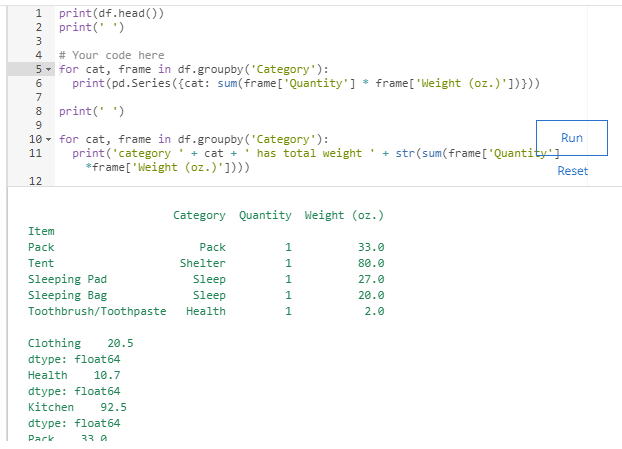

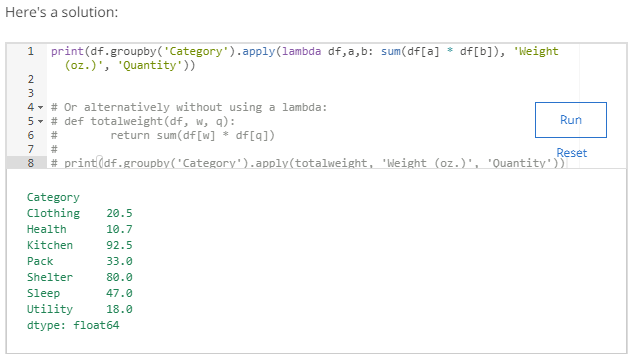

Now, I want to __flag__ a potential issue and using the aggregate method of group by objects. 

You see, when you pass in a _dictionary_ it can be used to either 
- to identify the columns to apply a function on or
- to name an output column if there's multiple functions to be run. 

The difference depends on the __keys__ that you pass in from the dictionary and how they're __named__.

In short, while much of the documentation and examples will talk about a _single_ groupby object, there's really _two_ different objects:
- The data frame groupby and 
- the series groupby.

And these objects behave a little bit _differently_ with aggregate. 

For instance, we take our census data and convert it into a __series__ with the state names as the index and only columns as the _census 2010 population_. 

And then we can group this by index using the level parameter.

In [33]:
print(type(df.groupby(level=0)['POPESTIMATE2010','POPESTIMATE2011']))
print(type(df.groupby(level=0)['POPESTIMATE2010']))

<class 'pandas.core.groupby.DataFrameGroupBy'>
<class 'pandas.core.groupby.SeriesGroupBy'>


In [34]:
#top returns a dataframe, bottom returns a series
print(type(df.groupby('CENSUS2010POP')))
print(type(df.groupby(level=0)['CENSUS2010POP']))

<class 'pandas.core.groupby.DataFrameGroupBy'>
<class 'pandas.core.groupby.SeriesGroupBy'>


In [53]:
#This uses the datatype "SeriesGroupBy". Note that since 'avg' is not a pre-existing column it creates a new column called 'avg'
(df.set_index('STNAME').groupby(level=0)['CENSUS2010POP']
    .agg({'avg': np.average, 'sum': np.sum})
    .head())

C:\Users\John\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


,avg,sum
STNAME,,
Alabama,71339.343284,4779736
Alaska,24490.724138,710231
Arizona,426134.466667,6392017
Arkansas,38878.906667,2915918
California,642309.586207,37253956


Then we call the agg method where the dictionary that has _both_ the numpy average and the numpy sum functions. 

PANDAS applies those functions to the __Series__ object and, since there's only _one_ column of data, it applies _both_ functions to that column and prints out the output. 

In [37]:
df.set_index('STNAME').groupby(level=0)['CENSUS2010POP'].agg({'avg' : np.average, 'sum' : np.sum}).head()

,avg,sum
STNAME,,
Alabama,71339.343284,4779736
Alaska,24490.724138,710231
Arizona,426134.466667,6392017
Arkansas,38878.906667,2915918
California,642309.586207,37253956


In [38]:
#this returns an error because agg funciton requires a level parameter set
#df.set_index('STNAME').groupby('CENSUS2010POP').agg({'avg' : np.average, 'sum' : np.sum})


We can do the same thing with a data frame instead of a series. 

We set the index to be the state name, we group by the index, and we project _two_ columns:
- the population estimate in 2010
- the population estimate in 2011. 

When we call aggregate with __two__ parameters, it builds a nice hierarchical column space and all of our functions are applied. 

In [39]:
#This uses the datatype DataFrameGroupBy. Now we are using two columns.
(df.set_index('STNAME').groupby(level=0)['POPESTIMATE2010','POPESTIMATE2011']
    .agg({'avg': np.average, 'sum': np.sum})
    .head())

avg                             sum                
           POPESTIMATE2010 POPESTIMATE2011 POPESTIMATE2010 POPESTIMATE2011
STNAME                                                                    
Alabama       71420.313433    71658.328358         4785161         4801108
Alaska        24621.413793    24921.379310          714021          722720
Arizona      427213.866667   431248.800000         6408208         6468732
Arkansas      38965.253333    39180.506667         2922394         2938538
California   643691.017241   650000.586207        37334079        37700034

Where the __confusion__ can come in is when we _change_ the labels of the dictionary we passed to aggregate, to correspond to the labels in our group data frame.

In this case, pandas recognizes that they're the _same_ and maps the functions directly to columns _instead_ of creating a hierarchically labeled column. 

From my perspective this is very odd behavior, not what I would expect given the labeling change. So just be aware of this when using the aggregate function.

In [40]:
#Confusion can occur when change labels of dictionary passed to "agg" func to correspond to labels in group dataframe.
#Pandas maps functions directly to columns instead of creatingf a hierarchically labeled column.

(df.set_index('STNAME').groupby(level=0)['POPESTIMATE2010','POPESTIMATE2011']
    .agg({'POPESTIMATE2010': np.average, 'POPESTIMATE2011': np.sum})
    .head())

,POPESTIMATE2010,POPESTIMATE2011
STNAME,,
Alabama,71420.313433,4801108
Alaska,24621.413793,722720
Arizona,427213.866667,6468732
Arkansas,38965.253333,2938538
California,643691.017241,37700034


 So that's the group by function. I use the group by function regularly in my work, and it's very handy for segmenting a data frame, working on small pieces of the data frame, and then creating bigger data frames later.

# Scales

Now that we've covered many of the mechanics of Pandas, I want to stop and talk for a moment about data types and scales. 

We've already seen that Pandas supports a number of different computational data types such as strings, integers and floating point numbers. What this doesn't capture is what we call the scale of the data. 

Let's say that we have a data frame of students and their academic levels such as being in grade 1 or grade 2 and grade 3. Is the difference between a student in grade 1 and a student in grade 2, the _same_ as the difference between a student in grade 8 and a student in grade 9. 

Well let's think about the final exam scores these students might get on assignments. Is the difference between an A and an A minus the same as the difference between an A minus and a B plus? 

> At the University of Michigan at least, the answer is usually no. 

We've intuitively seen some different scales, and as we move through data cleaning and statistical analysis and machine learning, it's important to clarify our knowledge and terminology. 

As a data scientist there _four_ scales that it's worth knowing.

1. The first is a __ratio scale__. In the ratio scale the measurements units are _equally_ spaced and mathematical operations, such as subtract, division, and multiplication are all valid.
    - Good examples of ratio scale measurements might be the height and weight.
2. The next scale is the __interval scale__. In the interval scale the measurement units are equally spaced like the ratio scale. But there's _no clear absence_ of value. That is there isn't a true zero, and so operation such as multiplication and division are _not_ valid. 
    - An example of the interval scale might be the temperatures measured in Celsius or Fahrenheit. Since there's never an absence of temperature and 0 degrees is a meaningful value of temperature. 
    - The direction on a campus might be another good example where 0 degrees on the campus doesn't indicate a lack of direction. 
    - For most of the work you do at data mining, the differences between the ratio and interval scales might _not_ be clearly apparent or important than the algorithm you're applying. But it's important to have this clear in your mind when you're applying advanced statistical tests.
3. The next scale is the __ordinal scale__, and this is also important. In the ordinal scale the order of values is important but the differences between the values are not equally spaced.
    - Here is a grading method that is used in many classes at the University of Michigan as a great example, where letter grades are given with pluses and minuses. But when you compare this to percentage values you see that a letter by itself covers 4% of the available grades and that a letter with a plus or minus is usually just 4% for the available grades. Based on this, it would be odd if there were as many students who received an A plus or A minus as there were who received a straight A. 
    - Ordinal data is very common in machine learning and can sometimes be a _challenge_ to work with. 
4. The last scale I'll mention is the __nominal__ scale which is often just called __categorical data__. 
    - Here the names of teams in a sport might be good example. There are a limited number of teams but changing their order or playing mathematical function to them is meaningless. 
    - Categorical values are very common and we generally refer to categories where there are only two possible values as binary. 
        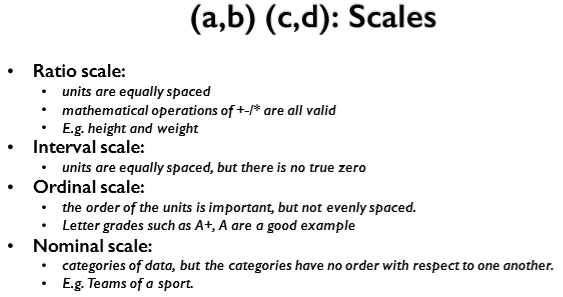

So why did I stop talking about Pandas and jump into this discussion of scale. Well, given how important they are in statistics and machine learning, Pandas has a number of interesting functions to deal with converting between measurement scales.

## Nominal data
Let's start first with nominal data, which in Pandas is called _categorical_ data. 

Pandas is actually has a built in type for categorical data and you could set a column of your data to categorical data by using the as __type method__. As type tries to change the underlying type of your data, in this case to category data. 

You can further change this to ordinal data by passing in an __ordered flags__ set to true and passing in the categories in an ordered fashion. 

Here's an example. Let's create a data frame of letter grades in the descending order. We can also set an index value of some more coarse-graind measure. 

In [41]:
df = pd.DataFrame(['A+', 'A', 'A-', 'B+', 'B', 'B-', 'C+', 'C', 'C-', 'D+', 'D'],
                  index=['excellent', 'excellent', 'excellent', 'good', 'good', 'good', 'ok', 'ok', 'ok', 'poor', 'poor'])
df.rename(columns={0: 'Grades'}, inplace=True)
df

,Grades
excellent,A+
excellent,A
excellent,A-
good,B+
good,B
good,B-
ok,C+
ok,C
ok,C-
poor,D+


Now when we instruct Pandas to render this as categorical data, we see that the dtype has been set as __category__ and that there are 11 different categories. 

In [42]:
#as type category means nominal which is no implicit ranking
df['Grades'].astype('category').head()

excellent    A+
excellent     A
excellent    A-
good         B+
good          B
Name: Grades, dtype: category
Categories (11, object): [A, A+, A-, B, ..., C+, C-, D, D+]

In [43]:
#this will give error because variables in df are nominal which cannot be used with bool
#df['Grades'].astype('category').head() > 'C'

If we want to indicate to Pandas that this data is in a logical order, we pass the __ordered equals true__ flag and we see those reflected in the category D type using the less than sign. 

What can you do with this? Well, ordinal data has ordering so it can help you with the __Boolean masking__.

For instance, if we have our list of grades and we compared them with a C. If we did this lexographically, we would that a C+ and a C- are both actually greater than a C. Instead of coding each of these to something which is lexographical, like a number, we can indicate that there's a clear order to the data. And then broadcasting will work as we expect.

We can then use a certain set of mathematical operators like minimum, maximum and others on the ordinal data.

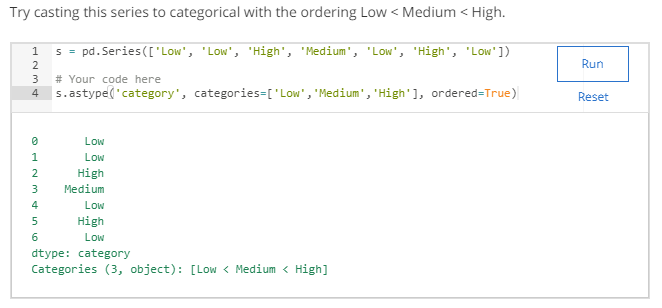

In [44]:
#Now it's ordinal which has implicit ranking. Note the < operator in the output below
#grades is extracted as a series since it's only the Grades
grades = df['Grades'].astype('category',
                             categories=['D', 'D+', 'C-', 'C', 'C+', 'B-', 'B', 'B+', 'A-', 'A', 'A+'],
                             ordered=True)
grades.head()

excellent    A+
excellent     A
excellent    A-
good         B+
good          B
Name: Grades, dtype: category
Categories (11, object): [D < D+ < C- < C ... B+ < A- < A < A+]

In [45]:
type(grades)

pandas.core.series.Series

In [46]:
grades > 'C'

excellent     True
excellent     True
excellent     True
good          True
good          True
good          True
ok            True
ok           False
ok           False
poor         False
poor         False
Name: Grades, dtype: bool

Sometimes it's useful to represent categorical values as each being a column with a true or a false as to whether that category applies. This is especially common in _feature extraction_, which is a topic in the third course in this specialization. 

## get_dummies()
Variables with a Boolean value are typically called dummy variables. And pandas has a built-in function called _get dummies_, which will __convert the values of a single column into multiple columns of 0's and 1's, indicating the presence of a dummy variable.__

## convert interval/ratio to category: cut()
There's one more function on scales that I'd like to talk about. And that's on __reducing a value which is on the interval or ratio scale, like a number grade, into one that is categorical like a letter grade__.

Now, this might seem a bit counter intuitive to you since you're losing information about the value. But it's useful on a couple of places. 

- First, if you're visualizing the frequencies of categories, and this can be an extremely useful approach and _histograms_ are regularly used with converted interval or racial data. And we'll take a look at histograms in the second course in this specialization. 
- Second, if you're using a machine learning _classification approach_ on data, then you need to be using _categorical_ data. So reducing dimensionality is useful there too. 

panda has a function called __cut__, which takes in argument which is some real like structure of a column or a data frame or a series. It also takes a number of bins to be used and all bins are kept at __equal__ spacing. 

Let's go back to our census data for an example. 
- We saw that we could group by state, then aggregate to get a list of the average county size by state. 
- If we further apply cut to this with say 10 bins, we can see that the states listed as categoricals using the average county size. 
- Here we see the states like Alabama and Alaska fall into the same category, while California and the District of Colombia fall into a very different category. 

In [55]:
df = pd.read_csv('census.csv')
df = df[df['SUMLEV']==50]
df = df.set_index('STNAME').groupby(level=0)['CENSUS2010POP'].agg({'avg': np.average})
pd.cut(df['avg'],10).head()

C:\Users\John\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


STNAME
Alabama         (11706.087, 75333.413]
Alaska          (11706.087, 75333.413]
Arizona       (390320.176, 453317.529]
Arkansas        (11706.087, 75333.413]
California    (579312.234, 642309.586]
Name: avg, dtype: category
Categories (10, interval[float64]): [(11706.087, 75333.413] < (75333.413, 138330.766] < (138330.766, 201328.118] < (201328.118, 264325.471] ... (390320.176, 453317.529] < (453317.529, 516314.881] < (516314.881, 579312.234] < (579312.234, 642309.586]]

In [56]:
pd.cut(df['avg'],3, labels=['small','medium','large']).head()

STNAME
Alabama        small
Alaska         small
Arizona       medium
Arkansas       small
California     large
Name: avg, dtype: category
Categories (3, object): [small < medium < large]

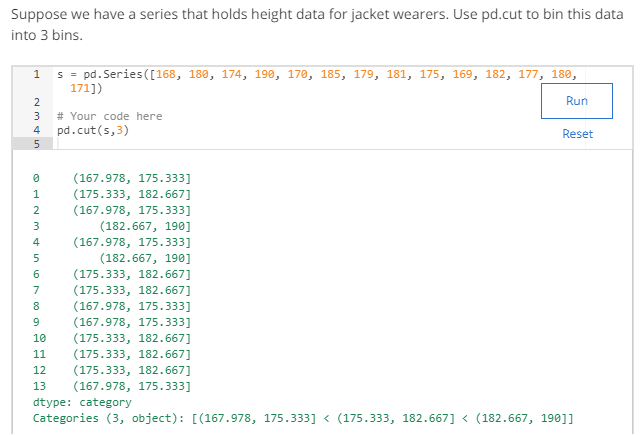

You can also add labels for the sizes [Small < Medium < Large].

> pd.cut(s, 3, labels=['Small', 'Medium', 'Large'])

Now, cutting is just one way to build categories from your data, and there's many other methods. 

For instance, cut gives you _interval_ data, where the spacing between each category is _equal_ sized. 

But sometimes you want to form categories __based on frequency__. You want the _number_ of items in each bin to be the _same_, __instead__ of the spacing between bins. 

It really depends on the shape of your data and what you're planning to do with it. And we'll look at some examples of this in the graphing and charting course for those of you who are enrolled in the specialization. 

That's it for this module of the course. There's a programming assignment to test your knowledge of this module's content and I'll see you back in the next module as a wrap up where we'll talk more about statistics and set up some basics for comparing results of analysis.

# Pivot Tables

A pivot table is a way of summarizing data in a data frame for a particular purpose. 

It makes _heavy_ use of the __aggregation function__. 

A pivot table is itself a data frame, where the 
- rows represent one variable that you're interested in, 
- the columns another, and 
- the cell's some aggregate value.

A pivot table also tends to includes _marginal_ values as well, which are the __sums__ for each column and row.

This allows you to be able to see the _relationship_ between two variables at just a glance.

Let's take a look at an example. Here we'll load a new data set, cars.csv. This data set comes from the Open Data Initiative of the Canadian government. And has information about the efficiency of different electric cars which are available for purchase. 

When we look at the head of the data frame, we'll see that there are model years, vendors, sizes of cars, and statistics, like how big the battery is in kilowatt hours. 

In [54]:
#http://open.canada.ca/data/en/dataset/98f1a129-f628-4ce4-b24d-6f16bf24dd64
import pandas as pd
import numpy as np

df = pd.read_csv('cars.csv')
df.head()

,YEAR,Make,Model,Size,(kW),Unnamed: 5,TYPE,CITY (kWh/100 km),HWY (kWh/100 km),COMB (kWh/100 km),CITY (Le/100 km),HWY (Le/100 km),COMB (Le/100 km),(g/km),RATING,(km),TIME (h)
0,2012,MITSUBISHI,i-MiEV,SUBCOMPACT,49,A1,B,16.9,21.4,18.7,1.9,2.4,2.1,0,NaN,100,7
1,2012,NISSAN,LEAF,MID-SIZE,80,A1,B,19.3,23.0,21.1,2.2,2.6,2.4,0,NaN,117,7
2,2013,FORD,FOCUS ELECTRIC,COMPACT,107,A1,B,19.0,21.1,20.0,2.1,2.4,2.2,0,NaN,122,4
3,2013,MITSUBISHI,i-MiEV,SUBCOMPACT,49,A1,B,16.9,21.4,18.7,1.9,2.4,2.1,0,NaN,100,7
4,2013,NISSAN,LEAF,MID-SIZE,80,A1,B,19.3,23.0,21.1,2.2,2.6,2.4,0,NaN,117,7


A pivot table allows us to pivot out one of these columns into a _new_ column headers and _compare_ it against another column as row indices. 

For instance, let's say we wanted to compare the _makes_ of electric vehicles versus the _years_ and that we wanted to do this comparison in terms of _battery capacity_.

To do this, we tell pandas we want
- the values to be kilowatts,
- the index to be the year and
- the columns to be the make. 
- Then we specify that the aggregation function, and here we'll use the NumPy mean. 

Here's the results. We see 
- there are NaN values for vendors who didn't have an entry in a given year like Ford in 2012. 
- And we see that most vendors don't have a change in battery capacity over the years, except for Tesla, as they've introduced several new models. 

In [55]:
df.pivot_table(values='(kW)', index='YEAR', columns='Make', aggfunc=np.mean)

Make,BMW,CHEVROLET,FORD,KIA,MITSUBISHI,NISSAN,SMART,TESLA
YEAR,,,,,,,,
2012,NaN,NaN,NaN,NaN,49.0,80.0,NaN,NaN
2013,NaN,NaN,107.0,NaN,49.0,80.0,35.0,280.000000
2014,NaN,104.0,107.0,NaN,49.0,80.0,35.0,268.333333
2015,125.0,104.0,107.0,81.0,49.0,80.0,35.0,320.666667
2016,125.0,104.0,107.0,81.0,49.0,80.0,35.0,409.700000


In [56]:
df.pivot_table?

Now, pivot tables aren't limited to one function that you might want to apply. You can pass __aggfunc__, a _list_ of the different functions to apply, and pandas will provide you with the result using _hierarchical_ column names. 

Here, I’ll also pass _margins_ equals true. And that you can see for each of the functions there's now an _all_ category, which shows the overall mean and the minimum values for a given year and a given vendor. 

In [57]:
#margins = True performs grand totals. Note that two functions are passed into aggfunc which then creates a hierarchical inde

df.pivot_table(values='(kW)', index='YEAR', columns='Make', aggfunc=[np.mean,np.min], margins=True)

mean                                                             \
Make    BMW CHEVROLET   FORD   KIA MITSUBISHI NISSAN SMART       TESLA   
YEAR                                                                     
2012    NaN       NaN    NaN   NaN       49.0   80.0   NaN         NaN   
2013    NaN       NaN  107.0   NaN       49.0   80.0  35.0  280.000000   
2014    NaN     104.0  107.0   NaN       49.0   80.0  35.0  268.333333   
2015  125.0     104.0  107.0  81.0       49.0   80.0  35.0  320.666667   
2016  125.0     104.0  107.0  81.0       49.0   80.0  35.0  409.700000   
All   125.0     104.0  107.0  81.0       49.0   80.0  35.0  345.478261   

                   amin                                                        \
Make         All    BMW CHEVROLET   FORD   KIA MITSUBISHI NISSAN SMART  TESLA   
YEAR                                                                            
2012   64.500000    NaN       NaN    NaN   NaN       49.0   80.0   NaN    NaN   
2013  158.444444    NaN       NaN  107.0   NaN       49.0   80.0  35.0  270.0   
2014  135.000000    NaN     104.0  107.0   NaN       49.0   80.0  35.0  225.0   
2015  181.428571  125.0     104.0  107.0  81.0       49.0   80.0  35.0  280.0   
2016  252.263158  125.0     104.0  107.0  81.0       49.0   80.0  35.0  283.0   
All   190.622642  125.0     104.0  107.0  81.0       49.0   80.0  35.0  225.0   

            
Make   All  
YEAR        
2012  49.0  
2013  35.0  
2014  35.0  
2015  35.0  
2016  35.0  
All   35.0

Suppose we have a DataFrame with price and ratings for different bikes, broken down by manufacturer and type of bicycle.

Create a pivot table that shows the mean price and mean rating for every 'Manufacturer' / 'Bike Type' combination.

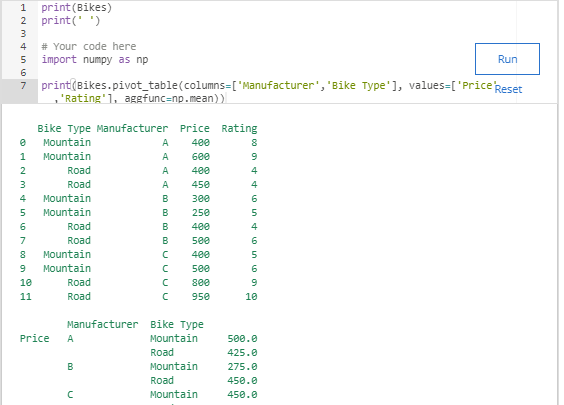

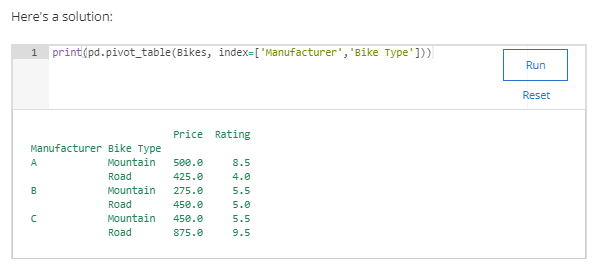

So that's pivot tables. 

This has been a pretty short description, but they're incredibly useful when dealing with numeric data. And of course, you can pass any function you want to the aggregate function, including those that you define yourself.

# Date Functionality in Pandas

Welcome to today's tutorial, where we'll be looking at the time series and date functionally in pandas. 

Pandas has four main time related classes. 
<ol>
    <li>Timestamp</li>
    <li>DatetimeIndex</li>
    <li>Period</li>
    <li>PeriodIndex</li>
</ol>

In [58]:
import pandas as pd
import numpy as np

## Timestamp

First, let's look at Timestamp. 

Timestamp represents a single timestamp and associates values with points in time. 

For example, let's create a timestamp using a string 9/1/2016 10:05AM, and here we have our timestamp. 

Timestamp is _interchangeable_ with Python's datetime in most cases. 

In [59]:
pd.Timestamp('9/1/2016 10:05AM')

Timestamp('2016-09-01 10:05:00')

## Period

Suppose we weren't interested in a specific point in time, and instead wanted a __span__ of time. This is where Period comes into play. 

Period represents a single time span, such as a specific day or month. Here we are creating a period that is January 2016, and here's an example of a period that is March 5th, 2016. 

In [60]:
pd.Period('1/2016')

Period('2016-01', 'M')

In [61]:
pd.Period('3/5/2016')

Period('2016-03-05', 'D')

## DatetimeIndex

The index of a timestamp is DatetimeIndex. 

Let's look at a quick example. First, let's create our example series t1, we'll use the Timestamp of September 1st, 2nd and 3rd of 2016.

When we look at the series, each Timestamp is the index and has a value associated with it, in this case, a, b and c. 

Looking at the type of our series index, we see that it's DatetimeIndex. 

In [62]:
t1 = pd.Series(list('abc'), [pd.Timestamp('2016-09-01'), pd.Timestamp('2016-09-02'), pd.Timestamp('2016-09-03')])
t1

2016-09-01    a
2016-09-02    b
2016-09-03    c
dtype: object

In [63]:
type(t1.index)

pandas.tseries.index.DatetimeIndex

## PeriodIndex

Similarly, the index of period is PeriodIndex. Let's create another example series t2. This time, we'll use the values d, e, and f and match them with the period September, October and November 2016

Looking at the type of the ts2.index, we can see that it's PeriodIndex. 

In [64]:
t2 = pd.Series(list('def'), [pd.Period('2016-09'), pd.Period('2016-10'), pd.Period('2016-11')])
t2

2016-09    d
2016-10    e
2016-11    f
Freq: M, dtype: object

In [65]:
type(t2.index)

pandas.tseries.period.PeriodIndex

## Converting to Datetime

Now, let's look into how to convert to Datetime. Suppose we have a list of dates as strings. If we create a DataFrame using these dates as the index. And some randomly generated data, this is the DataFrame we get. 

Looking at the index we can see that it’s pretty messy and the dates are all in different formats.

Using pandas to_datetime, pandas will try to convert these to Datetime and put them in a standard format. 

to_datetime also has options to change the date parse order. 





In [66]:
d1 = ['2 June 2013', 'Aug 29, 2014', '2015-06-26', '7/12/16']
ts3 = pd.DataFrame(np.random.randint(10, 100, (4,2)), index=d1, columns=list('ab'))
ts3

,a,b
2 June 2013,42,41
"Aug 29, 2014",76,56
2015-06-26,60,61
7/12/16,64,82


In [67]:
ts3.index = pd.to_datetime(ts3.index)
ts3

,a,b
2013-06-02,42,41
2014-08-29,76,56
2015-06-26,60,61
2016-07-12,64,82


For example, we can pass in the argument dayfirst = True to parse the date in European date format. 

In [68]:
pd.to_datetime('4.7.12', dayfirst=True)

Timestamp('2012-07-04 00:00:00')

## Timedeltas

Timedeltas are differences in times. We can see that when we take the difference between September 3rd and September 1st, we get a Timedelta of two days.

In [69]:
pd.Timestamp('9/3/2016')-pd.Timestamp('9/1/2016')

Timedelta('2 days 00:00:00')

 We can also do something like find what the date and time is for 12 days and three hours past September 2nd, at 8:10 AM. 

In [70]:
pd.Timestamp('9/2/2016 8:10AM') + pd.Timedelta('12D 3H')

Timestamp('2016-09-14 11:10:00')

## Working with Dates in a Dataframe

Next, let's look at a few tricks for working with dates in a DataFrame. 

Suppose we want to look at nine measurements, taken bi-weekly, every Sunday, starting in October 2016. 

Using date_range, we can create this DatetimeIndex. 

In [71]:
#Creates a date every other Sunday (every 2 weeks)
dates = pd.date_range('10-01-2016', periods=9, freq='2W-SUN')
dates

DatetimeIndex(['2016-10-02', '2016-10-16', '2016-10-30', '2016-11-13',
               '2016-11-27', '2016-12-11', '2016-12-25', '2017-01-08',
               '2017-01-22'],
              dtype='datetime64[ns]', freq='2W-SUN')

Now, let's create a DataFrame using these dates, and some random data, and see what we can do with it.




In [72]:
df = pd.DataFrame({'Count 1': 100 + np.random.randint(-5, 10, 9).cumsum(),
                  'Count 2': 120 + np.random.randint(-5, 10, 9)}, index=dates)
df

,Count 1,Count 2
2016-10-02,107,116
2016-10-16,111,116
2016-10-30,113,127
2016-11-13,120,129
2016-11-27,117,124
2016-12-11,114,129
2016-12-25,118,121
2017-01-08,125,116
2017-01-22,127,121


First, we can check what day of the week a specific date is. For example, here we can see that all the dates in our index are on a Sunday. 

In [73]:
df.index.weekday_name

array(['Sunday', 'Sunday', 'Sunday', 'Sunday', 'Sunday', 'Sunday',
       'Sunday', 'Sunday', 'Sunday'], dtype=object)

We can use __diff__ to find the difference between each date's value. 

In [74]:
#calculates the delta between rows
df.diff()

,Count 1,Count 2
2016-10-02,NaN,NaN
2016-10-16,4.0,0.0
2016-10-30,2.0,11.0
2016-11-13,7.0,2.0
2016-11-27,-3.0,-5.0
2016-12-11,-3.0,5.0
2016-12-25,4.0,-8.0
2017-01-08,7.0,-5.0
2017-01-22,2.0,5.0


Suppose we wanted to know what the mean count is for each month in our DataFrame.

We can do this using __resample__. 

In [19]:
#returns the mean counts every month
df.resample('M').mean()

,Count 1,Count 2
2016-10-31,108.0,124.666667
2016-11-30,115.5,126.000000
2016-12-31,107.0,123.500000
2017-01-31,103.0,124.000000


We can use partial string indexing to find values from a particular year, or from a particular month, or we can even slice on a range of dates.

In [20]:
df['2017']

,Count 1,Count 2
2017-01-08,105,125
2017-01-22,101,123


In [21]:
df['2016-12']

,Count 1,Count 2
2016-12-11,109,121
2016-12-25,105,126


For example, here we only want the values from December 2016 _onwards_. 

In [22]:
df['2016-12':]

,Count 1,Count 2
2016-12-11,109,121
2016-12-25,105,126
2017-01-08,105,125
2017-01-22,101,123


Another cool thing we can do is change the frequency of our dates in our DataFrame using asfreq. 

In [76]:
#changes frequency to weekly from every 2 weeks
df.asfreq('W')

,Count 1,Count 2
2016-10-02,107.0,116.0
2016-10-09,NaN,NaN
2016-10-16,111.0,116.0
2016-10-23,NaN,NaN
2016-10-30,113.0,127.0
2016-11-06,NaN,NaN
2016-11-13,120.0,129.0
2016-11-20,NaN,NaN
2016-11-27,117.0,124.0
2016-12-04,NaN,NaN


If we use this to change the frequency from bi-weekly to weekly, we'll end up with _missing_ values every other week. 

So let's use the __forward fill__ method on those missing values.

In [75]:
#forward fill to avoid NaN
df.asfreq('W', method='ffill')

,Count 1,Count 2
2016-10-02,107,116
2016-10-09,107,116
2016-10-16,111,116
2016-10-23,111,116
2016-10-30,113,127
2016-11-06,113,127
2016-11-13,120,129
2016-11-20,120,129
2016-11-27,117,124
2016-12-04,117,124


One last thing I wanted to briefly touch upon is plotting time series.
 
- Importing matplotlib.pyplot, and 
- using the iPython magic %mapplotlib inline, will allow you to visualize the time series in the notebook

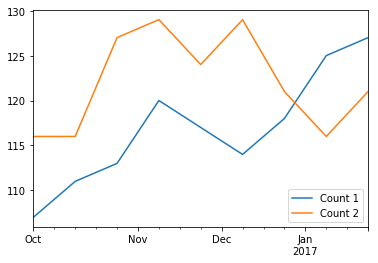

In [77]:
import matplotlib.pyplot as plt
%matplotlib inline

df.plot()

In the next course, we will learn more about understanding and creating visualizations. Thanks for watching, see you next time.